Colab cell 1 — Setup

In [ ]:
# Colab cell 1 — Setup

# We explicitly pin the library versions to ensure reproducibility.
# This avoids subtle breaking changes in TensorFlow or NumPy that could
# otherwise affect model training, quantization, or TFLite conversion.

# In particular:
# - TensorFlow version is fixed to match our TFLM compatibility expectations
# - NumPy is capped below 2.1 to avoid known incompatibilities with TF at the time
# - tensorflow-datasets is required for loading KMNIST

!pip -q install -U "tensorflow==2.19.1" "tensorflow-datasets>=4.9.0" "numpy<2.1"


print("Installed pinned versions.")
# After installing or updating core libraries in Colab, we must restart the runtime once.
# This ensures that all subsequent imports use the newly installed versions and prevents mixed or partially loaded states.
print("After this run we do once: Runtime -> Restart runtime (manual).")

Installed pinned versions.
After this run we do once: Runtime -> Restart runtime (manual).


Colab cell 2 (imports + version check)

In [ ]:
import os, numpy as np, tensorflow as tf, tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# We import all core libraries used throughout the notebook:
# - NumPy for numerical operations and array handling
# - TensorFlow for model definition, training, and TFLite conversion
# - tensorflow_datasets for loading the KMNIST dataset in a standardized way
# - Matplotlib for visualization and sanity checks during development

print("TF:", tf.__version__)
print("NumPy:", np.__version__)

TF: 2.19.1
NumPy: 2.0.2


Colab cell 3 — Load KMNIST + denoising pairs (noisy input, clean target)

In [ ]:
IMG_H, IMG_W = 28, 28
BATCH = 128
SEED = 42
# We use a stateless random number generator for noise generation.

#This is important because it guarantees reproducibility: given the same input image and index, the generated noise will always be identical.
#This makes training, evaluation, and quantization deterministic across runs.

def add_noise(x, seed):
    noise = tf.random.stateless_normal(
        tf.shape(x),
        seed=seed,
        mean=0.0,
        stddev=0.35
    )

    # After adding noise, we clip the values to the valid image range [0, 1].
    return tf.clip_by_value(x + noise, 0.0, 1.0)

#=========================================================================================
# This preprocessing function creates the input–target pairs for the denoising task.
# For each dataset element, we return:
# - x_noisy: the noisy input image
# - x: the original clean image (used as training target)
def preprocess(example, idx):

    # Convert the image to float32 and normalize it to [0, 1]
    x = tf.cast(example["image"], tf.float32) / 255.0

    # We construct a deterministic per-sample seed using:
    # - a global fixed SEED
    # - the sample index provided by enumerate()
    # This ensures that each image always receives the same noise pattern.
    seed = tf.stack([
        tf.cast(SEED, tf.int32),
        tf.cast(idx, tf.int32)
    ])

    x_noisy = add_noise(x, seed)
    return x_noisy, x

#=========================================================================================
# Load the raw KMNIST datasets.
# We enable file shuffling for the training split, but keep the test split fixed.
ds_train_raw = tfds.load("kmnist", split="train", shuffle_files=True)
ds_test_raw  = tfds.load("kmnist", split="test",  shuffle_files=False)

# We enumerate the datasets to obtain a stable index for each element.
# This index is required for deterministic, stateless noise generation.


# The training pipeline:
# - shuffle the dataset
# - enumerate to attach a stable index
# - apply preprocessing to create noisy/clean pairs
# - batch the data
# - prefetch for better pipeline performance
ds_train = (ds_train_raw
            .shuffle(60000, seed=SEED)
            .enumerate()
            .map(lambda i, ex: preprocess(ex, i),
                 num_parallel_calls=tf.data.AUTOTUNE)
            .batch(BATCH)
            .prefetch(tf.data.AUTOTUNE))

# The test pipeline is similar, but WITHOUT shuffling.
# This ensures consistent evaluation and deterministic test samples.
ds_test = (ds_test_raw
           .enumerate()
           .map(lambda i, ex: preprocess(ex, i),
                num_parallel_calls=tf.data.AUTOTUNE)
           .batch(BATCH)
           .prefetch(tf.data.AUTOTUNE))

#=========================================================================================
# Here is also a small calibration dataset for post-training quantization.
# This subset is only used to estimate activation ranges during INT8 conversion.
# A batch size of 1 is commonly used for representative datasets.
ds_calib = (tfds.load("kmnist", split="train[:2000]", shuffle_files=False)
            .enumerate()
            .map(lambda i, ex: preprocess(ex, i),
                 num_parallel_calls=tf.data.AUTOTUNE)
            .batch(1))

print("Datasets ready.")

Datasets ready.


Colab cell 4 — Build the TFLM-friendly int8 autoencoder (using Conv2D + Conv2DTranspose)

In [ ]:
def build_autoencoder():
    # Define the model input.
    # Each input sample is a single-channel (grayscale) 28x28 image representing a noisy KMNIST character.
    inp = tf.keras.Input(shape=(28, 28, 1), name="noisy")

    # ---------------- Encoder ----------------
    # The encoder progressively reduces spatial resolution while increasing the number of feature channels.
    # We use strided convolutions instead of pooling to keep the operator set simple and TFLM-friendly (based on old failed versions).

    x = tf.keras.layers.Conv2D(
        filters=8,
        kernel_size=3,
        strides=2,
        padding="same",
        activation="relu",
        name="enc_conv1"
    )(inp)   # Output shape: 14x14x8

    x = tf.keras.layers.Conv2D(
        filters=16,
        kernel_size=3,
        strides=2,
        padding="same",
        activation="relu",
        name="enc_conv2"
    )(x)     # Output shape: 7x7x16

    # ---------------- Bottleneck ----------------
    # The bottleneck operates at the lowest spatial resolution.
    # This layer captures the compressed representation of the input
    # while keeping the operator set minimal and quantization-friendly.
    z = tf.keras.layers.Conv2D(
        filters=16,
        kernel_size=3,
        strides=1,
        padding="same",
        activation="relu",
        name="bottleneck"
    )(x)     # Output shape: 7x7x16


    # ---------------- Decoder ----------------
    # The decoder reconstructs the image by progressively increasing
    # the spatial resolution using transposed convolutions.
    # TransposeConv is explicitly chosen to mirror the encoder structure
    # and remains supported by TensorFlow Lite Micro in INT8 (also based on old experiences with the failed TFLM).

    x = tf.keras.layers.Conv2DTranspose(
        filters=8,
        kernel_size=3,
        strides=2,
        padding="same",
        activation="relu",
        name="dec_tconv1"
    )(z)     # Output shape: 14x14x8

    out = tf.keras.layers.Conv2DTranspose(
        filters=1,
        kernel_size=3,
        strides=2,
        padding="same",
        activation="sigmoid",
        name="dec_tconv2"
    )(x)     # Output shape: 28x28x1

#=========================================================================================
    # Assemble the autoencoder model.
    # The output uses a sigmoid activation to produce values in [0, 1],
    # matching the normalized image representation.
    model = tf.keras.Model(inp, out, name="kmnist_dae_tflm_int8")

    # We optimize the model using Adam and mean squared error (MSE),
    # which is a standard choice for image reconstruction tasks.
    # The focus here is stable convergence rather than maximum accuracy.
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="mse"
    )

    return model

# Build the model and print a summary for verification.
model = build_autoencoder()
model.summary()

Model: "kmnist_dae_tflm_int8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ noisy (InputLayer)              │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_conv1 (Conv2D)              │ (None, 14, 14, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_conv2 (Conv2D)              │ (None, 7, 7, 16)       │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Conv2D)             │ (None, 7, 7, 16)       │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_tconv1 (Conv2DTranspose)    │ (None, 14, 14, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_tconv2 (Conv2DTranspose)    │ (None, 28, 28, 1)      │            73 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,801 (18.75 KB)

 Trainable params: 4,801 (18.75 KB)

 Non-trainable params: 0 (0.00 B)

Colab cell 5 — Train

In [ ]:
EPOCHS = 5

# We train the autoencoder using the prepared training pipeline.
# The number of epochs is intentionally kept small:
# - our goal is not state-of-the-art denoising performance
# - we only need a functionally correct model for embedded deployment
# - shorter training reduces iteration time during development and debugging


# Validation is performed on the test dataset to ensure that the model generalizes and does not simply memorize the training noise.
history = model.fit(
    ds_train,
    validation_data=ds_test,
    epochs=EPOCHS
)

print("Training done.")

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step - loss: 0.1164 - val_loss: 0.0233
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - loss: 0.0198 - val_loss: 0.0187
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - loss: 0.0169 - val_loss: 0.0172
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - loss: 0.0158 - val_loss: 0.0165
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - loss: 0.0151 - val_loss: 0.0159
Training done.


Colab cell 6 — Convert to FULL INT8 TFLite (int8 input + int8 output)

In [ ]:
def representative_data_gen():
    # This generator provides representative input samples for post-training quantization.
    # The samples must:
    # - be float32
    # - have the same shape as the model input (1, 28, 28, 1)

    # During conversion, TensorFlow Lite uses these samples to estimate
    # activation ranges for each layer, which is essential for correct INT8 scaling.
    for x_noisy, _ in ds_calib.take(1000):
        yield [tf.cast(x_noisy, tf.float32)]

#=========================================================================================
# Create a TensorFlow Lite converter from the trained Keras model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Enable default optimizations.
# This activates post-training quantization and allows the converter
# to apply size and performance optimizations suitable for embedded targets.
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Attach the representative dataset to calibrate activations.
# Without this step, full integer quantization would not be possible !!!
converter.representative_dataset = representative_data_gen

#===================
# Force full integer quantization.
# - Only INT8 kernels are allowed
# - Input tensor is INT8
# - Output tensor is INT8
#===================
# This guarantees that no floating-point operations remain in the final model,
# which is a strict requirement for execution on microcontrollers. <might be where we failed once earlier>
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

#=========================================================================================
# At this point, the trained floating-point model is transformed into
# a fully quantized INT8 TensorFlow Lite model.
tflite_int8 = converter.convert()

# Save the quantized model
out_dir = "export_int8"
os.makedirs(out_dir, exist_ok=True)
tflite_path = os.path.join(out_dir, "kmnist_dae_int8.tflite")

with open(tflite_path, "wb") as f:
    f.write(tflite_int8)

# Printing feedback on whether the model fits typical embedded memory constraints.
print("Saved:", tflite_path, "size:", len(tflite_int8), "bytes")

Saved artifact at '/tmp/tmpz2rers_v'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='noisy')
Output Type:
  TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)
Captures:
  134862449328208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134862450638288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134862450638480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134862449330320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134862449328592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134862449329936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134862449331088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134862449330896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134862449330128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134862449330704: TensorSpec(shape=(), dtype=tf.resource, name=None)


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Saved: export_int8/kmnist_dae_int8.tflite size: 11712 bytes


Colab cell 7 — Op audit (confirm it matches STM32 resolver)

In [ ]:
# This step prints the operator list contained in the generated TFLite graph.
# We expect to see mainly:
# - CONV_2D
# - TRANSPOSE_CONV
# - LOGISTIC

# In practice, additional helper ops (such as SHAPE, PACK, STRIDED_SLICE)
# may also appear due to how certain layers (e.g. transposed convolutions)
# are implemented internally. In our model here is also the same.


#<This is added after figuring out why mismatches here often cause runtime failures on the MCU and causes failed tests.>

# !!! This analysis step is critical for embedded deployment:
# TFLM requires all used operators to be explicitly registered in the op resolver at compile time.
# By inspecting the operator list here, we can ensure that our embedded
# resolver configuration matches the actual model graph exactly.

tf.lite.experimental.Analyzer.analyze(model_path=tflite_path)

=== export_int8/kmnist_dae_int8.tflite ===

Your TFLite model has '1' subgraph(s). In the subgraph description below,
T# represents the Tensor numbers. For example, in Subgraph#0, the CONV_2D op takes
tensor #0 and tensor #16 and tensor #15 as input and produces tensor #17 as output.

Subgraph#0 main(T#0) -> [T#28]
  Op#0 CONV_2D(T#0, T#16, T#15[37168, -7749, 9439, 19903, 91, ...]) -> [T#17]
  Op#1 CONV_2D(T#17, T#14, T#13[4978, 5043, 3575, 4475, 1441, ...]) -> [T#18]
  Op#2 CONV_2D(T#18, T#12, T#11[804, 2314, -564, 1452, 377, ...]) -> [T#19]
  Op#3 SHAPE(T#19) -> [T#20]
  Op#4 STRIDED_SLICE(T#20, T#1[0], T#2[1], T#2[1]) -> [T#21]
  Op#5 PACK(T#21, T#3[14], T#3[14], T#4[8]) -> [T#22]
  Op#6 TRANSPOSE_CONV(T#22, T#10, T#19, T#9[76, -151, 182, 275, -112, ...]) -> [T#23]
  Op#7 SHAPE(T#23) -> [T#24]
  Op#8 STRIDED_SLICE(T#24, T#1[0], T#2[1], T#2[1]) -> [T#25]
  Op#9 PACK(T#25, T#5[28], T#5[28], T#6[1]) -> [T#26]
  Op#10 TRANSPOSE_CONV(T#26, T#8, T#23, T#7[-120]) -> [T#27]
  Op#11 LOGISTIC

Colab cell 8 — INT8 inference sanity check (run 1 batch + quick MSE)

In [ ]:
# ADDED TO PREVENT LATER FAILED

# Create a TFLite interpreter for the exported INT8 model.
# This is our last sanity check on the "desktop" side before going embedded:
# if inference is wrong here, it will also be wrong on the microcontroller.
interpreter = tf.lite.Interpreter(model_path=tflite_path)
interpreter.allocate_tensors()

#=========================================================================================
# Extract input/output tensor metadata.
# We use this to confirm:
# - the model really has INT8 input and INT8 output
# - the shapes match our expectations (1, 28, 28, 1)
# - the quantization parameters (scale, zero-point) are available
in_det = interpreter.get_input_details()[0]
out_det = interpreter.get_output_details()[0]

print("Input dtype/shape:", in_det["dtype"], in_det["shape"], "quant:", in_det["quantization"])
print("Output dtype/shape:", out_det["dtype"], out_det["shape"], "quant:", out_det["quantization"])

#=========================================================================================
# Take a few deterministic evaluation samples from the test pipeline.
# ds_test yields (noisy_input, clean_target) pairs.
num_eval = 8
x_noisy, x_clean = next(iter(ds_test.unbatch().batch(num_eval)))

# Quantize input float -> int8 using the model input quantization parameters.
# Quantization mapping is: q = round(real / scale + zero_point)
# This is the same mapping we later apply when generating embedded test inputs !!!
in_scale, in_zero = in_det["quantization"]
xq = tf.cast(tf.round(x_noisy / in_scale + in_zero), tf.int8).numpy()

#=========================================================================================
# Run inference sample-by-sample.
# This is slightly slower than a big batch, but it is robust and mirrors how
# we typically operate on-device (one input at a time).
yq_list = []
for i in range(num_eval):
    interpreter.set_tensor(in_det["index"], xq[i:i+1])
    interpreter.invoke()
    yq_list.append(interpreter.get_tensor(out_det["index"]))
yq = np.concatenate(yq_list, axis=0)

# Dequantize output int8 -> float to compute a simple reconstruction metric.
# Dequantization mapping is: real = (q - zero_point) * scale
out_scale, out_zero = out_det["quantization"]
y_hat = (yq.astype(np.float32) - out_zero) * out_scale
y_hat = np.clip(y_hat, 0.0, 1.0)

# Compute MSE between reconstructed image and clean target.
# This gives us a quick numeric indicator that the INT8 model behaves similarly
# to the float model (at least on a small sample set).
mse = np.mean((y_hat - x_clean.numpy())**2)
print("INT8 TFLite recon MSE (on", num_eval, "samples):", mse)

Input dtype/shape: <class 'numpy.int8'> [ 1 28 28  1] quant: (0.003921568859368563, -128)
Output dtype/shape: <class 'numpy.int8'> [ 1 28 28  1] quant: (0.00390625, -128)
INT8 TFLite recon MSE (on 8 samples): 0.015537811


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


Colab cell 9 — Visualization (clean vs noisy vs INT8 recon + float recon + “after encoded”)

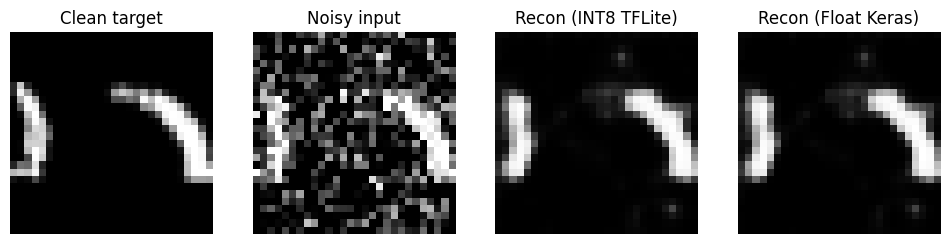

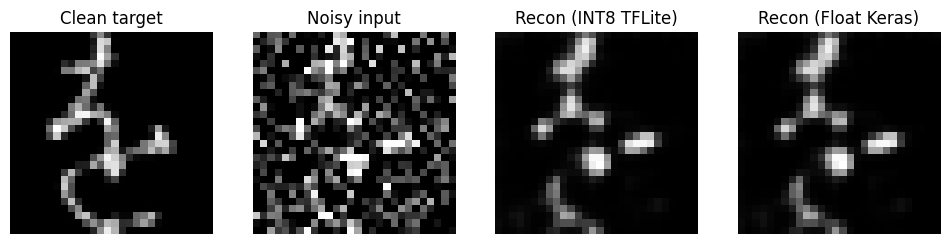

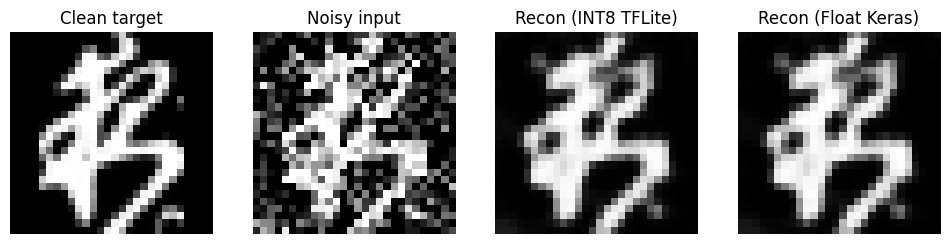

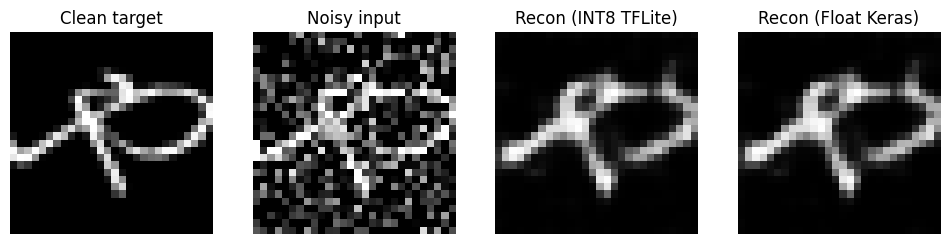

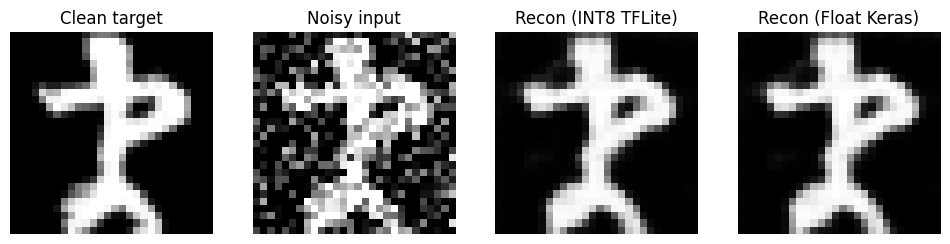

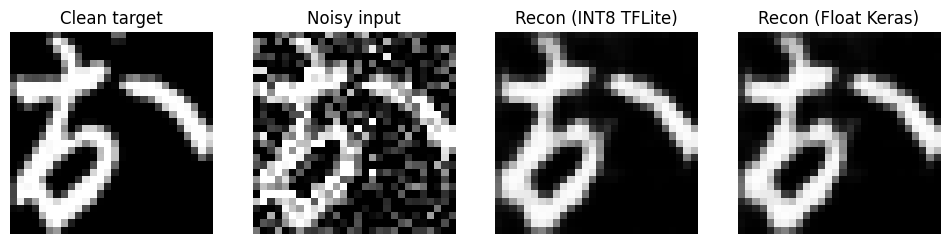

In [ ]:
num_show = 6
x_noisy, x_clean = next(iter(ds_test.unbatch().batch(num_show)))

#=========================================================================================
# ---------------- INT8 path: quantize -> invoke -> dequantize ----------------
# We first run the exported INT8 TFLite model on a few samples and dequantize the output back to float for visualization.
# This provides a quick qualitative check that INT8 reconstruction is reasonable.

# Quantize input float -> int8 using the input quantization parameters.
# This matches how the model expects input data during embedded inference.
in_scale, in_zero = in_det["quantization"]
xq = tf.cast(tf.round(x_noisy / in_scale + in_zero), tf.int8).numpy()

# TFLite INT8 inference (sample-by-sample for robustness).
# Running one-by-one mirrors typical embedded usage and avoids any surprises with batching behavior.
yq_list = []
for i in range(num_show):
    interpreter.set_tensor(in_det["index"], xq[i:i+1])
    interpreter.invoke()
    yq_list.append(interpreter.get_tensor(out_det["index"]))
yq = np.concatenate(yq_list, axis=0)

# Dequantize output int8 -> float for plotting.
# Dequantization mapping: real = (q - zero_point) * scale
out_scale, out_zero = out_det["quantization"]
y_hat_int8 = (yq.astype(np.float32) - out_zero) * out_scale
y_hat_int8 = np.clip(y_hat_int8, 0.0, 1.0)

#=========================================================================================
# ---------------- Float reference path (Keras) ----------------
# We also compute the float model output as a baseline reference.
# The goal is not perfect equality, but to confirm that INT8 reconstruction
# follows the same overall structure and denoising behavior.
y_hat_float = model.predict(x_noisy, verbose=0)

# ---------------- Bottleneck inspection ----------------
# For debugging and intuition, we look at the bottleneck activations.
# This is a float-only inspection step (not done on-device), but it helps us
# confirm that the encoder produces non-trivial representations.
encoder_probe = tf.keras.Model(model.input, model.get_layer("bottleneck").output)
z = encoder_probe.predict(x_noisy, verbose=0)  # (N,7,7,16)

#=========================================================================================
# Plot one sample as a row:
# clean target, noisy input, INT8 reconstruction, float reconstruction
def show_row(i):
    fig, ax = plt.subplots(1, 4, figsize=(12, 3))
    ax[0].imshow(x_clean[i].numpy().squeeze(), cmap="gray"); ax[0].set_title("Clean target")
    ax[1].imshow(x_noisy[i].numpy().squeeze(), cmap="gray"); ax[1].set_title("Noisy input")
    ax[2].imshow(y_hat_int8[i].squeeze(), cmap="gray");      ax[2].set_title("Recon (INT8 TFLite)")
    ax[3].imshow(y_hat_float[i].squeeze(), cmap="gray");     ax[3].set_title("Recon (Float Keras)")
    for a in ax: a.axis("off")
    plt.show()

#=========================================================================================
# Plot the 16 bottleneck feature maps as a 4x4 grid.
# This helps us see whether the latent channels respond differently and carry
# structured information rather than collapsing to a constant.
def show_bottleneck_grid(i):
    chans = z[i]  # (7,7,16)
    fig, ax = plt.subplots(4, 4, figsize=(6, 6))
    k = 0
    for r in range(4):
        for c in range(4):
            ax[r, c].imshow(chans[:, :, k], cmap="gray")
            ax[r, c].axis("off")
            ax[r, c].set_title(f"z{k}", fontsize=8)
            k += 1
    plt.suptitle("Encoded representation (bottleneck feature maps)")
    plt.tight_layout()
    plt.show()

#=========================================================================================
# Show qualitative results for several examples.
# This is usually the fastest way to catch obvious deployment or quantization issues.
for i in range(num_show):
    show_row(i)

# Optional: show bottleneck maps for a selected sample.
# (We keep it commented out to avoid generating too many plots by default.)

#show_bottleneck_grid(0)

Colab cell 10 — Export model + pre-quantized INT8 test samples (for STM32 later)

In [ ]:
out_dir = "export_int8"
os.makedirs(out_dir, exist_ok=True)

#=========================================================================================
# ---------------- Export quantized model as C array ----------------
# We convert the raw INT8 TFLite flatbuffer into a C-compatible byte array.
# This allows us to compile the model directly into the STM32 firmware without any file system or runtime loading on the device.
model_cc_path = os.path.join(out_dir, "kmnist_dae_int8_model.cc")
data = np.frombuffer(tflite_int8, dtype=np.uint8)

with open(model_cc_path, "w") as f:
    f.write('#include <cstdint>\n\n')

    # We align the model data to 16 bytes to satisfy typical alignment
    # requirements of embedded memory access and optimized kernels.
    f.write('alignas(16) const unsigned char g_model[] = {\n')

    # Write the model bytes in a readable hex format.
    # Splitting into small chunks keeps the generated file manageable.
    for i in range(0, len(data), 12):
        chunk = data[i:i+12]
        f.write("  " + ", ".join([f"0x{b:02x}" for b in chunk]) + ",\n")

    f.write('};\n')

    # Store the model length explicitly so the embedded code can
    # verify or reference the model size if needed.
    f.write(f'const unsigned int g_model_len = {len(data)};\n')

print("Saved model C array:", model_cc_path)

#=========================================================================================
# ---------------- Export embedded test samples ----------------
# In addition to the model, we export a small set of deterministic test samples.
# This allows the STM32 firmware to run inference and validation without
# implementing any floating-point preprocessing or data loading on-device.

N_SAMPLES = 8
x_noisy_s, x_clean_s = next(iter(ds_test.unbatch().batch(N_SAMPLES)))

# Quantize the noisy inputs using the model input quantization parameters.
# This ensures that the embedded inputs match exactly what the model expects !!!
in_scale, in_zero = in_det["quantization"]
xq_s = tf.cast(
    tf.round(x_noisy_s / in_scale + in_zero),
    tf.int8
).numpy()   # Shape: (N, 28, 28, 1)

#==============================================
# Store the clean targets as uint8 (0..255).
# These are used only as reference data on the microcontroller to compute a coarse correctness metric. !!!
targets_u8 = tf.cast(
    tf.round(x_clean_s * 255.0),
    tf.uint8
).numpy()

# Flatten both arrays so they can be indexed easily on the embedded side.
xq_flat = xq_s.reshape(-1)
t_flat  = targets_u8.reshape(-1)

samples_cc_path = os.path.join(out_dir, "kmnist_dae_int8_test_samples.cc")
with open(samples_cc_path, "w") as f:
    f.write('#include <cstdint>\n\n')

    # Export basic metadata so the embedded code knows how many samples and which dimensions are stored.
    f.write(f'const int g_test_num_samples = {N_SAMPLES};\n')
    f.write('const int g_test_h = 28;\n')
    f.write('const int g_test_w = 28;\n')
    f.write('const int g_test_c = 1;\n\n')

    # Quantized noisy inputs for the model input tensor.
    # Layout is flattened [N][28][28][1].
    f.write('// Quantized noisy inputs for model input tensor (int8), flattened [N][28][28][1]\n')
    f.write('alignas(16) const int8_t g_test_inputs_int8[] = {\n')
    for i in range(0, len(xq_flat), 16):
        chunk = xq_flat[i:i+16]
        f.write("  " + ", ".join([str(int(v)) for v in chunk]) + ",\n")
    f.write('};\n\n')

    # Clean targets stored as uint8 (0..255).
    # These are flattened in the same order as the inputs so that input and target pixels correspond one-to-one.
    f.write('// Clean targets as uint8 (0..255) for reference only, flattened [N][28][28][1]\n')
    f.write('alignas(16) const uint8_t g_test_targets_u8[] = {\n')
    for i in range(0, len(t_flat), 16):
        chunk = t_flat[i:i+16]
        f.write("  " + ", ".join([str(int(v)) for v in chunk]) + ",\n")
    f.write('};\n')

print("Saved test samples C array:", samples_cc_path)

# Print all exported artifacts for a final sanity check.
print("\nExported files:")
for fn in sorted(os.listdir(out_dir)):
    print(" -", fn)

Saved model C array: export_int8/kmnist_dae_int8_model.cc
Saved test samples C array: export_int8/kmnist_dae_int8_test_samples.cc

Exported files:
 - kmnist_dae_int8.tflite
 - kmnist_dae_int8_model.cc
 - kmnist_dae_int8_model.h
 - kmnist_dae_int8_test_samples.cc
 - kmnist_dae_int8_test_samples.h


In [ ]:
import os

out_dir = "export_int8"


# These headers allow the STM32 firmware to reference the model and
# test sample data defined in the corresponding .cc files.
model_h_path = os.path.join(out_dir, "kmnist_dae_int8_model.h")
samples_h_path = os.path.join(out_dir, "kmnist_dae_int8_test_samples.h")

# ---------------- Model header ----------------
# This header exposes the quantized TFLite model as an external symbol.
# The actual data lives in kmnist_dae_int8_model.cc and is linked at compile time.
with open(model_h_path, "w") as f:
    f.write("#pragma once\n")
    f.write("#include <cstdint>\n\n")

    # Expose the raw model byte array and its length.
    # These symbols are used by TFLM on the embedded side to map and validate the model.
    f.write("// TFLite model data (generated in Colab)\n")
    f.write("extern const unsigned char g_model[];\n")
    f.write("extern const unsigned int g_model_len;\n")


# ---------------- Test samples header ----------------
# This header exposes the embedded test inputs and reference targets.
# They are used by the STM32 firmware to run deterministic inference
# and perform on-device validation without any external data source.
with open(samples_h_path, "w") as f:
    f.write("#pragma once\n")
    f.write("#include <cstdint>\n\n")

    # Metadata describing how many samples are embedded and
    # the expected input tensor dimensions.
    f.write("// Pre-quantized INT8 test inputs + reference targets (generated in Colab)\n")
    f.write("extern const int g_test_num_samples;\n")
    f.write("extern const int g_test_h;\n")
    f.write("extern const int g_test_w;\n")
    f.write("extern const int g_test_c;\n\n")

    # Quantized noisy inputs for the model input tensor (INT8).
    # Clean targets are stored as uint8 (0..255) for reference only.
    f.write("extern const int8_t  g_test_inputs_int8[];\n")
    f.write("extern const uint8_t g_test_targets_u8[];\n")

print("Saved:", model_h_path)
print("Saved:", samples_h_path)


# List all exported artifacts to confirm that the model and
# test sample files are complete and ready for embedded integration.
print("\nExported files now:")
for fn in sorted(os.listdir(out_dir)):
    print(" -", fn)

Saved: export_int8/kmnist_dae_int8_model.h
Saved: export_int8/kmnist_dae_int8_test_samples.h

Exported files now:
 - kmnist_dae_int8.tflite
 - kmnist_dae_int8_model.cc
 - kmnist_dae_int8_model.h
 - kmnist_dae_int8_test_samples.cc
 - kmnist_dae_int8_test_samples.h
